# Learn simulation basics through the dynamics of a single qubit
**Simulate and visualize quantum system dynamics in Boulder Opal**

In this tutorial you will simulate an ideal single qubit, visualize the qubit's dynamics on an interactive Bloch sphere, and implement a basic quantum gate.
You will carry out simulations in two different cases: for a constant Hamiltonian and a time-dependent one.
Through this tutorial you will get introduced to a few key important concepts in Boulder Opal, such as [creating *graphs*](https://docs.q-ctrl.com/boulder-opal/topics/understanding-graphs-in-boulder-opal) representing the quantum dynamics calculation and making quick and easy visual representations of data with the [Q-CTRL Visualizer package](https://docs.q-ctrl.com/references/qctrl-visualizer/).

## Simulating single-qubit dynamics with a constant Hamiltonian

Your first task will be to simulate and visualize dynamics of a single qubit.
In particular, the system is described by a constant Hamiltonian of the form
$$
H(t) = \frac{1}{2}\Big(\Omega \sigma_- + \mathrm{H. c.} \Big) + \delta \sigma_z  ,
$$
where $\Omega$ is the Rabi drive,
$\delta$ is the detuning,
H.c. represents the Hermitian conjugate,
$\sigma_- = \left(\begin{smallmatrix} 0 & 1 \\ 0 & 0 \end{smallmatrix}\right)$, and
$\sigma_z = \left(\begin{smallmatrix} 1 & 0 \\ 0 & -1 \end{smallmatrix}\right)$.
(Note that Boulder Opal uses $\hbar = 1$, so Hamiltonians should be defined with angular velocity units.)

To achieve that, you will create a computational graph that solves the Schrödinger equation,
$$i \frac{\mathrm{d} U(t)}{\mathrm{d} t} = H(t)U(t)  ,$$
to obtain the unitary time-evolution operators $U(t)=\mathcal{T} \exp(-i \int_0^t H(s) \mathrm{d}s)$, and calculate the evolution of the qubit's state, $|\psi(t)\rangle = U(t)|\psi(0)\rangle$, from its initial state $|\psi(0)\rangle = |0\rangle$.

You will execute the graph to carry out the computation, and extract the values of the unitaries and qubit state at intermediate times. You will also visualize the time-dependent dynamics of the qubit both from their populations and on the Bloch sphere.

### 1. Import libraries and start a Boulder Opal session

Before doing any calculation with Boulder Opal, you always need to import the necessary libraries and start a session.

In this case, import the `numpy`, `qctrlvisualizer`, and `boulderopal` packages.
To learn more about installing Boulder Opal, see the [Get started](https://docs.q-ctrl.com/boulder-opal/get-started) guide.

In [1]:
# Import packages.
import numpy as np
import qctrlvisualizer
import boulderopal as bo

### 2. Create the graph defining the simulation

The relationships between inputs and outputs of a quantum system calculation in Boulder Opal are represented by a graph.
To find step-by-step instructions and examples on how to perform computations in Boulder Opal using graphs, see [this user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-calculate-and-optimize-with-graphs).

To perform the qubit simulation you will create a graph that represents the calculation, containing nodes that connect the graph inputs (the parameters and operators defined above) with its outputs (the unitaries and evolved states).

#### Create the graph object

Start by creating the graph object that will define the calculation.
You can do this by creating a `boulderopal.Graph` instance.

In [2]:
graph = bo.Graph()

#### Create signals for the Hamiltonian terms

Most simulations in Boulder Opal start by defining the time-dependent coefficients for the different Hamiltonian terms, in this case, $\Omega$ and $\delta$.
As they are constant, we create piecewise-constant (PWC) coefficients with a single segment with the `graph.constant_pwc` graph operation.

In [3]:
# (Constant) Hamiltonian parameters.
omega = 2 * np.pi * 1.0e6  # rad/s
delta = 2 * np.pi * 0.4e6  # rad/s

# Total duration of the simulation.
duration = 2e-6  # s

# Hamiltonian term coefficients.
omega_signal = graph.constant_pwc(constant=omega, duration=duration)
delta_signal = graph.constant_pwc(constant=delta, duration=duration)

#### Construct the Hamiltonian

By multiplying each signal by its corresponding operator and adding the two terms, you can now construct the full Hamiltonian of the system.
You can use `graph.pauli_matrix` to generate the basic operators and `graph.hermitian_part` to obtain the Hermitian part of $\Omega(t) \sigma_-$.

In [4]:
# Total Hamiltonian, [Ω σ- + H.c.]/2 + δ σz.
hamiltonian = graph.hermitian_part(
    omega_signal * graph.pauli_matrix("M")
) + delta_signal * graph.pauli_matrix("Z")

And with that you have now encoded the full Hamiltonian of your system in Boulder Opal, including the time-dependent control signals.
Every other simulation you will perform will involve some variation of this step.

#### Solve Schrödinger's equation

You can now use the `graph.time_evolution_operators_pwc` graph node to solve the Schrödinger's equation with a given time-dependent `hamiltonian` $H(t)$.
This node returns the unitary evolution operators $U(t)$ at the requested `sample_times`.

Assign a `name` to the node, so that you can extract its value later.

In [5]:
# Times at which to sample the simulation.
sample_times = np.linspace(0.0, duration, 100)

# Time-evolution operators, U(t).
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=sample_times, name="unitaries"
)

You've now created a graph node containing the time-evolution operator whose generator is the Hamiltonian previously encoded.

#### Calculate evolved states

Now that you have a node representing the unitary time evolution, you can calculate the state of the qubit at different times,
$$ |\psi(t) \rangle = U(t) |\psi(0) \rangle  , $$
by performing the matrix multiplication (with the Python operator `@`) of the unitaries with the initial state of the qubit.

Again, assign a `name` to the node.

In [6]:
# Initial state of the qubit, |0⟩.
initial_state = graph.fock_state(2, 0)[:, None]

# Evolved states, |ψ(t)⟩ = U(t) |0⟩
evolved_states = unitaries @ initial_state
evolved_states.name = "states"

This graph node you've just created represents the time-dependent state of the qubit during the simulation.

### 3. Execute the graph

You now have a graph that relates the system's parameters and operators with some outputs.
You can execute it with the `boulderopal.execute_graph` function to evaluate the graph and get the outputs as concrete arrays of data.
Pass to it the `output_node_names` of the nodes you want to retrieve, in this case, the `unitaries` and the evolved `states`.

In [7]:
result = bo.execute_graph(graph=graph, output_node_names=["unitaries", "states"])

Your task (action_id="1828684") is queued.
Your task (action_id="1828684") has started.
Your task (action_id="1828684") has completed.


### 4. Extract the calculation outputs

After a graph is complete all of the output data is stored in the dictionary returned by `boulderopal.execute_graph`.
In particular, `result["output"]` is a dictionary containing the values of the nodes you have requested when calculating the graph.

You can extract the final unitary matrix and state vector values by accessing this dictionary. 

In [8]:
unitaries = result["output"]["unitaries"]["value"]
print(f"Shape of calculated unitaries: {unitaries.shape}")

states = result["output"]["states"]["value"]
print(f"Shape of calculated evolved states: {states.shape}")

Shape of calculated unitaries: (100, 2, 2)
Shape of calculated evolved states: (100, 2, 1)


You can print the final state and final unitary to see that the Rabi coupling has transferred some population between the two computational basis states.

In [9]:
print(f"Final unitary:\n{np.round(unitaries[-1], 3)}")
print()
print(f"Final state:\n{np.round(states[-1], 3)}")

Final unitary:
[[-0.191-0.613j -0.   -0.766j]
 [ 0.   -0.766j -0.191+0.613j]]

Final state:
[[-0.191-0.613j]
 [ 0.   -0.766j]]


### 5. Visualize the simulation results

You can now analyze the results of the simulation by visualizing relevant observables.

#### Plotting the qubit populations

Start by calculating the time evolution of the computational basis populations from the array containing the state of the qubit at the sample times you specified above.

In [10]:
# Calculate qubit populations |⟨ψ|0⟩|².
qubit_populations = np.abs(states.squeeze()) ** 2

You can now plot them with the `plot_population_dynamics` function from the [Q-CTRL Visualizer](https://docs.q-ctrl.com/references/qctrl-visualizer/) package.

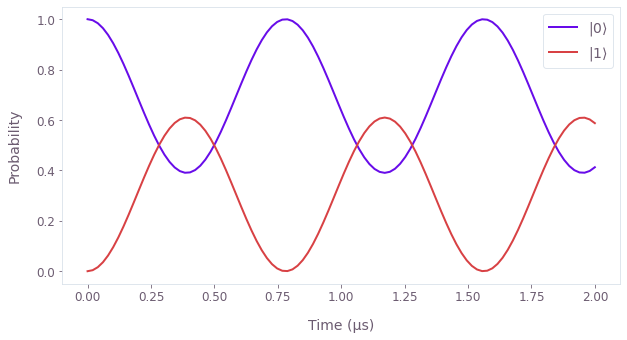

In [11]:
# Plot populations.
qctrlvisualizer.plot_population_dynamics(
    sample_times, {rf"$|{k}\rangle$": qubit_populations[:, k] for k in [0, 1]}
)

In this case, you can see that the qubit's state performs incomplete Rabi oscillations due to the presence of the detuning $\delta$ in the coupling.

#### Visualizing the dynamics on the Bloch sphere

Another way to visualize these dynamics is to see the trajectory they trace on the Bloch sphere.
You can easily do this with the `display_bloch_sphere` function from the [Q-CTRL Visualizer](https://docs.q-ctrl.com/references/qctrl-visualizer/) package, which creates a fully interactive visualization that you can manipulate while watching the time evolution.

In [12]:
qctrlvisualizer.display_bloch_sphere(states.squeeze())

<IPython.core.display.Javascript object>

## Simulating a $\pi/2$ gate in a single qubit with a time-dependent Hamiltonian

The next simulation you will perform will implement a $\pi/2$ gate for a qubit,
$$
U_{\pi/2} = \frac{1}{\sqrt{2}} \left( \begin{array}{cc} 1 & -1 \\ 1 & 1 \end{array} \right)  ,
$$
by applying a Gaussian pulse for the time-dependent Rabi drive,
$$
\Omega(t) = \Omega_\mathrm{max} \exp(- a (t-t_0)^2)  .
$$
Assuming the system is in resonance ($\delta = 0$), so the Hamiltonian describing the single-qubit dynamics simplifies to
$$
H(t) = \frac{1}{2}\Big(\Omega(t) \sigma_- + \mathrm{H. c.} \Big)  .
$$

Assuming the driving field is purely imaginary (or more generally applied with a fixed phase),
$\Omega(t) = -i \omega(t)$ with real $\omega(t)$,
then one can show that the resulting unitary will also be a $\pi/2$ gate as long as the integral of the Rabi rate is equal to $\pi/2$, that is,
$$
\int_0^T |\Omega(t)| \mathrm{d}t = \frac{\pi}{2}  .
$$

Many experiments require the inputs to be discretized in the time domain over constantly spaced segments.
A piecewise-constant (PWC) description of the pulse is better suited to describe the control in that case.
In particular, the PWC control pulse takes discrete values $\{\Omega_n\}$ at $N$ different segments:
$$
\Omega(t) = \Omega_n \quad \mathrm{for} \ t \in \left[ \frac{(n-1)T}{N}, \frac{nT}{N} \right)  .
$$

Under this discretization, the above integral becomes a sum and the equation can be solved to obtain the precise duration of the pulse to implement a $\pi/2$ pulse:
$$
T = \frac{\pi N}{2 \sum_{n=1}^{N} |\Omega_n|}  .
$$

In what follows, you will learn how to use a Boulder Opal to simulate this PWC pulse in a qubit and verify that this digitized Gaussian pulse implements a $\pi/2$ gate.

### 1. Define the time-dependent signal

Start by defining the values and duration of the Gaussian pulse to use in the simulation.
In this case, you can use NumPy to create the values of a Gaussian function at the different PWC segments, and calculate its duration so that it implements a $\pi/2$ gate.

In [13]:
# Gaussian pulse parameters.
omega_max = 2.0 * np.pi * 1e6  # Hz
segment_count = 50
times = np.linspace(-3, 3, segment_count)
omega_values = -1j * omega_max * np.exp(-(times**2))

# Total duration of the pulse to achieve a π/2 gate.
pulse_duration = 0.5 * segment_count * np.pi / np.sum(np.abs(omega_values))

You can use the `plot_controls` function in the [Q-CTRL Visualizer](https://docs.q-ctrl.com/references/qctrl-visualizer/) to represent the real and imaginary parts of the Gaussian pulse that you just defined.

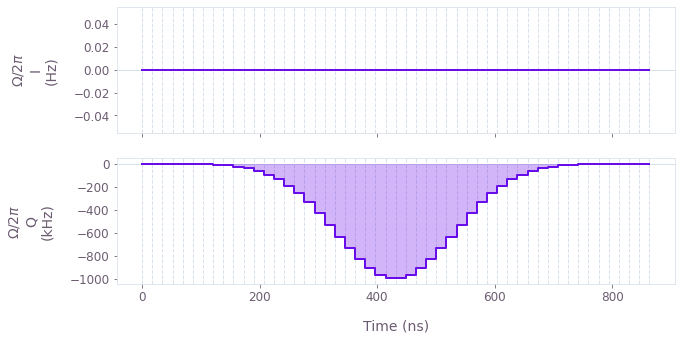

In [14]:
# Plot Gaussian pulse.
qctrlvisualizer.plot_controls(
    {
        "$\\Omega$": {
            "values": omega_values,
            "durations": np.repeat(pulse_duration / segment_count, segment_count),
        }
    },
    polar=False,
)

### 2. Create the graph defining the simulation

The graph in this example is very similar to the previous case, so you can follow roughly the same steps as before.

#### Create the graph object

In [15]:
graph = bo.Graph()

#### Create signals for the Hamiltonian terms

Create the signal $\Omega(t)$ for the Rabi drive in the Hamiltonian using the `omega_values` you defined above.
You can use the `graph.pwc_signal` operation that will create equally long segments out of the total `pulse_duration`.

In [16]:
# Times at which to sample the simulation.
sample_times = np.linspace(0.0, pulse_duration, 100)

# Time-dependent Hamiltonian term coefficient.
omega_signal = graph.pwc_signal(values=omega_values, duration=pulse_duration)

#### Construct the Hamiltonian and solve Schrödinger's equation

Construct the rest of the graph in the same way you did in the previous example.
Remember to assign a `name` to the nodes whose values want to extract out of the graph.

In [17]:
# Total Hamiltonian, [Ω σ- + H.c.]/2
hamiltonian = graph.hermitian_part(omega_signal * graph.pauli_matrix("M"))

# Time-evolution operators, U(t).
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=sample_times, name="unitaries"
)

# Initial state of the qubit, |0⟩.
initial_state = graph.fock_state(2, 0)[:, None]

# Evolved states, |ψ(t)⟩ = U(t) |0⟩
evolved_states = unitaries @ initial_state
evolved_states.name = "states"

### 3. Execute the graph and retrieve the results

Use the `boulderopal.execute_graph` function to evaluate the graph and retrieve the arrays with the values that you requested.

In [18]:
# Execute the graph.
result = bo.execute_graph(graph=graph, output_node_names=["unitaries", "states"])

# Retrieve values of the calculation
unitaries = result["output"]["unitaries"]["value"]
states = result["output"]["states"]["value"]

Your task (action_id="1828691") is queued.
Your task (action_id="1828691") has started.
Your task (action_id="1828691") has completed.


### 4. Analyze the results

#### Final unitary and state

You can now check that the final unitary correctly implements the expected unitary gate, 
$$ U_{\pi/2} = \frac{1}{\sqrt{2}} \left( \begin{array}{cc} 1 & -1 \\ 1 & 1 \end{array} \right)  ,$$
and that the qubit has reached the expected final state
$$ |\psi(T) \rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1 \rangle)  .$$
(Remember that $1/\sqrt{2} \simeq 0.7071$.)

In [19]:
print("Unitary gate implemented by the Gaussian pulse:")
print(unitaries[-1])
print()
print("Final state after the gate:")
print(states[-1])

Unitary gate implemented by the Gaussian pulse:
[[ 0.70710678+0.j -0.70710678+0.j]
 [ 0.70710678+0.j  0.70710678+0.j]]

Final state after the gate:
[[0.70710678+0.j]
 [0.70710678+0.j]]


#### Population dynamics

You can again represent the qubit populations to visualize the intermediate dynamics reaching the target state.

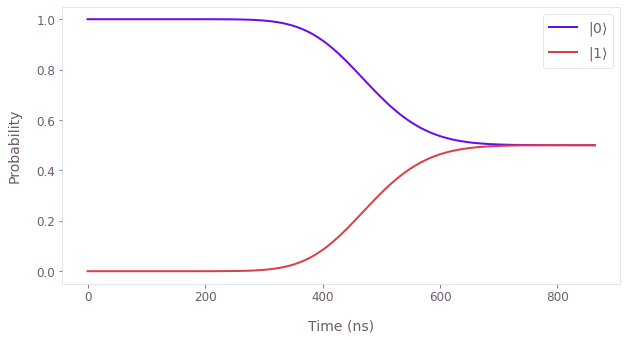

In [20]:
# Calculate qubit populations |⟨ψ|0⟩|².
qubit_populations = np.abs(states.squeeze()) ** 2

# Plot populations.
qctrlvisualizer.plot_population_dynamics(
    sample_times, {rf"$|{k}\rangle$": qubit_populations[:, k] for k in [0, 1]}
)

Our [user guides](https://docs.q-ctrl.com/boulder-opal/user-guides/) can help you extend this simulation tool to any quantum system.
In particular, you might be interested in reading about [Hamiltonians with nonlinear dependences](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-controls-with-nonlinear-dependences), [noisy quantum systems](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-simulate-quantum-dynamics-subject-to-noise-with-graphs), [quantum circuits](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-simulate-multi-qubit-circuits-in-quantum-computing), or [open quantum systems](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-simulate-open-system-dynamics).

If you want to learn more about Boulder Opal and its capabilities, visit our [topics page](https://docs.q-ctrl.com/boulder-opal/topics).